In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./Data/Prediction_data/"
input_data_file = "input_df.csv"
pred_data_file = "pred_df.csv"

input_df = pd.read_csv(os.path.join(data_path, input_data_file))
pred_df = pd.read_csv(os.path.join(data_path, pred_data_file))
pre2019 = pd.read_csv("./Data/Prediction_data/pred_2019_transformer.csv")  
arima_data = pd.read_csv("./Data/Prediction_data/arima_2019.csv",index_col=0, parse_dates=True)
code = pd.read_csv("./Data/Prediction_data/CODE_2019_4141.csv", index_col=0)
columns = ['4141', '4212', '4283', '4354', '4425', '4496', '4567', '4638', '4709', '4780']

In [63]:
arima_data=arima_data["4141"]

In [64]:
def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)


In [65]:
#scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_raw = pd.read_csv(os.path.join("./Data/Observed_data/sequence_array_2019.csv"))
length = len(df_raw)
num_train = int(length * 0.4)
num_test = int(length*0.5)
num_vali = int(length*0.1)
border1s = [0, num_train - 24, num_train + num_vali - 24]
border2s = [num_train, num_train + num_vali, num_train + num_vali +num_test]


border1 = border1s[0]
border2 = border2s[0]   
df_data = df_raw[columns]
train_data = df_data[border1:border2]
scaler.fit(train_data.values)
pred_df_sacle = pred_df[['4141', '4212', '4283', '4354', '4425', '4496', '4567', '4638', '4709', '4780']].values
pred_df_unsacle = scaler.inverse_transform(pred_df_sacle)
pred_df_unsacle = pd.DataFrame(pred_df_unsacle)
pred_df_unsacle.columns = columns 
pred_df_unsacle_columns = pred_df_unsacle
pred_df_unsacle_columns["Time"] = pred_df["Time"]

input_df_sacle = input_df[['4141', '4212', '4283', '4354', '4425', '4496', '4567', '4638', '4709', '4780']].values
input_df_unsacle = scaler.inverse_transform(input_df_sacle)
input_df_unsacle = pd.DataFrame(input_df_unsacle)
input_df_unsacle.columns = columns 
input_df_unsacle_columns = input_df_unsacle
input_df_unsacle_columns["Time"] = input_df["Time"]


In [66]:
dfraw = df_raw
dfraw.index = pd.to_datetime(df_raw.data)
dfraw = dfraw["4141"]

In [67]:
pred_df_unsacle_columns.index = pd.to_datetime(pred_df_unsacle_columns.Time)
pred = pred_df_unsacle_columns["4141"]
input_df_unsacle_columns.index = pd.to_datetime(input_df_unsacle_columns.Time)
real = input_df_unsacle_columns["4141"]

pre_tran = pre2019[['4141', '4212', '4283', '4354', '4425', '4496', '4567', '4638', '4709', '4780',"Time"]]
pre_tran = pd.DataFrame(pre_tran)
pre_tran.columns = ['4141', '4212', '4283', '4354', '4425', '4496', '4567', '4638', '4709', '4780',"Time"]

pre_tran.index = pd.to_datetime(pre_tran["Time"])
pre_tran = pre_tran["4141"]
pre_tran

Time
2019-01-01 00:00:00    4.891580
2019-01-01 01:00:00    6.001166
2019-01-01 02:00:00    7.254738
2019-01-01 03:00:00    8.067039
2019-01-01 04:00:00    8.501527
                         ...   
2019-12-31 19:00:00    2.315597
2019-12-31 20:00:00    2.574318
2019-12-31 21:00:00    2.949594
2019-12-31 22:00:00    3.639751
2019-12-31 23:00:00    4.688686
Name: 4141, Length: 8760, dtype: float64

In [68]:
from scipy.stats import pearsonr

def calculate_pearson_windows(pred, real, common_start, common_end):
    """
    计算给定时间序列在每个1天窗口内的皮尔逊相关系数和P值。

    :param pred: 预测值的Pandas Series，以时间为索引。
    :param real: 实际值的Pandas Series，以时间为索引。
    :param common_start: 共同的起始日期。
    :param common_end: 共同的结束日期。
    :return: 包含每个窗口开始日期、结束日期、相关系数和P值的DataFrame。
    """
    # 定义一个空的DataFrame来存储每个1天窗口的结果
    results = pd.DataFrame(columns=['Start Date', 'End Date', 'CC', 'P-Value'])

    start_date = common_start

    while start_date + pd.Timedelta(days=1) <= common_end:
        end_date = start_date + pd.Timedelta(days=1)
        
        # 根据当前窗口选择数据
        pred_window = pred.loc[start_date:end_date]
        real_window = real.loc[start_date:end_date]
        
        if len(pred_window) > 0 and len(real_window) > 0:
            # 计算当前窗口的相关系数和P值
            cc, p_value = pearsonr(pred_window, real_window)
            
            # 将结果添加到DataFrame中
            results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
        
        # 更新窗口的起始日期为下一个1天周期的开始
        start_date = end_date

    return results

In [69]:
common_start = max(arima_data.index.min(), real.index.min())
common_end = min(arima_data.index.max(), real.index.max())

pred_aligned = arima_data.loc[common_start:common_end]
real_aligned = real.loc[common_start:common_end]

arima_results = calculate_pearson_windows(pred_aligned, real_aligned, common_start, common_end)

/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be remove

In [70]:
arima_results

,Start Date,End Date,CC,P-Value
0,2019-01-01,2019-01-02,0.961509,2.129988e-14
1,2019-01-02,2019-01-03,0.967683,2.940080e-15
2,2019-01-03,2019-01-04,0.984117,9.024158e-19
3,2019-01-04,2019-01-05,0.951190,3.108930e-13
4,2019-01-05,2019-01-06,0.976429,8.142371e-17
...,...,...,...,...
357,2019-12-24,2019-12-25,0.973132,3.611196e-16
358,2019-12-25,2019-12-26,0.933602,9.810439e-12
359,2019-12-26,2019-12-27,0.947913,6.457939e-13
360,2019-12-27,2019-12-28,0.920741,7.048785e-11


In [71]:
tran_results

,Start Date,End Date,CC,P-Value,Source,Model
0,2019-01-01,2019-01-02,0.955328,1.145382e-13,Transport,Transformer
1,2019-01-02,2019-01-03,0.973275,3.399534e-16,Transport,Transformer
2,2019-01-03,2019-01-04,0.979289,1.866322e-17,Transport,Transformer
3,2019-01-04,2019-01-05,0.903318,6.346340e-10,Transport,Transformer
4,2019-01-05,2019-01-06,0.977770,4.179162e-17,Transport,Transformer
...,...,...,...,...,...,...
59,2019-03-01,2019-03-02,0.941416,2.416365e-12,Transport,Transformer
60,2019-03-02,2019-03-03,0.977067,5.959413e-17,Transport,Transformer
61,2019-03-03,2019-03-04,0.935086,7.620022e-12,Transport,Transformer
62,2019-03-04,2019-03-05,0.948303,5.934519e-13,Transport,Transformer


In [72]:

common_start = max(pre_tran.index.min(), real.index.min())
common_end = min(pre_tran.index.max(), real.index.max())

# 现在，根据共同的时间范围筛选 pred 和 real
pred_aligned = pre_tran.loc[common_start:common_end]
real_aligned = real.loc[common_start:common_end]

tran_results = calculate_pearson_windows(pred_aligned, real_aligned, common_start, common_end)

/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be remove

In [73]:
common_start = max(pred.index.min(), real.index.min())
common_end = min(pred.index.max(), real.index.max())

# 现在，根据共同的时间范围筛选 pred 和 real
pred_aligned = pred.loc[common_start:common_end]
real_aligned = real.loc[common_start:common_end]

diffusion_results = calculate_pearson_windows(pred_aligned, real_aligned, common_start, common_end)


/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be remove

In [74]:
common_start = max(pred.index.min(), real.index.min())
common_end = min(pred.index.max(), real.index.max())
code.index = pd.to_datetime(code.index)
code = code["4141"]
# 现在，根据共同的时间范围筛选 pred 和 real
pred_aligned = code.loc[common_start:common_end]
real_aligned = real.loc[common_start:common_end]

code_results = calculate_pearson_windows(pred_aligned, real_aligned, common_start, common_end)


/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Start Date': start_date, 'End Date': end_date, 'CC': cc, 'P-Value': p_value}, ignore_index=True)
/tmp/ipykernel_39320/510403223.py:30: FutureWarning: The frame.append method is deprecated and will be remove

In [75]:
from datetime import datetime, timedelta


df = pd.read_csv('./Data/Observed_data/omni2_2019.lst.txt', sep='\s+', header=0, names=['Year', 'DayOfYear', 'Hour', 'Dst'])
df['DateTime'] = df.apply(lambda row: (datetime(int(row['Year']), 1, 1) + timedelta(days=int(row['DayOfYear']) - 1, hours=int(row['Hour']))), axis=1)
df.set_index('DateTime', inplace=True)

# 选择2018年10月19日到2018年10月25日的数据
start_date = '2019-01-01'
end_date = '2019-12-31'
mask = (df.index >= start_date) & (df.index <= end_date)
selected_data = df.loc[mask]
selected_data

,Year,DayOfYear,Hour,Dst
DateTime,,,,
2019-01-01 03:00:00,2019,1,3,-2
2019-01-01 04:00:00,2019,1,4,1
2019-01-01 05:00:00,2019,1,5,-3
2019-01-01 06:00:00,2019,1,6,-6
2019-01-01 07:00:00,2019,1,7,-12
...,...,...,...,...
2019-12-30 19:00:00,2019,364,19,5
2019-12-30 20:00:00,2019,364,20,6
2019-12-30 21:00:00,2019,364,21,10


In [76]:
dst_averages = []
cc_results = code_results
df = selected_data
for index, row in cc_results.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    # 选取当前窗口内的Dst值
    dst_window = df.loc[start_date:end_date]
    # 计算平均值
    avg_dst = dst_window['Dst'].mean()
    dst_averages.append(avg_dst)

# 将平均Dst值添加到cc_results DataFrame
cc_results['AvgDst'] = dst_averages
cc_results.head()

,Start Date,End Date,CC,P-Value,AvgDst
0,2019-01-01,2019-01-02,0.878048,8.065376e-09,-4.4
1,2019-01-02,2019-01-03,0.937132,5.326620e-12,NaN
2,2019-01-03,2019-01-04,0.952250,2.427713e-13,NaN
3,2019-01-04,2019-01-05,0.959411,3.881746e-14,2.0
4,2019-01-05,2019-01-06,0.917603,1.084362e-10,-11.5


In [77]:
# 为每个DataFrame添加一个来源列
diffusion_results['Source'] = 'Diffusion'
tran_results['Source'] = 'Transport'
arima_results['Source'] = 'ARIMA'
code_results['Source'] = 'C1PG'
# 合并三个DataFrame
all_results = pd.concat([diffusion_results, tran_results, arima_results,code_results], ignore_index=True)

# 定义区间，注意区间是左开右闭的
bins = [0, 0.3, 0.6, 0.9, 0.95, 1]
labels = ['0-0.3', '0.3-0.6', '0.6-0.9', '0.9-0.95', '0.95-1']

## 分类
all_results['CC_Range'] = pd.cut(all_results['CC'], bins=bins, labels=labels, include_lowest=True)

# 分别计算每个来源的CC范围百分比
for source in all_results['Source'].unique():
    source_data = all_results[all_results['Source'] == source]
    percentage = source_data['CC_Range'].value_counts(normalize=True).sort_index() * 100
    percentage_df = percentage.reset_index()
    percentage_df.columns = ['CC Range', 'Percentage']
    print(f"{source} CC Range Distribution:\n{percentage_df}\n")

Diffusion CC Range Distribution:
   CC Range  Percentage
0     0-0.3    0.000000
1   0.3-0.6    0.000000
2   0.6-0.9    1.104972
3  0.9-0.95   13.259669
4    0.95-1   85.635359

Transport CC Range Distribution:
   CC Range  Percentage
0     0-0.3    0.000000
1   0.3-0.6    0.000000
2   0.6-0.9    2.486188
3  0.9-0.95   21.546961
4    0.95-1   75.966851

ARIMA CC Range Distribution:
   CC Range  Percentage
0     0-0.3    0.000000
1   0.3-0.6    0.000000
2   0.6-0.9    3.591160
3  0.9-0.95   20.994475
4    0.95-1   75.414365

C1PG CC Range Distribution:
   CC Range  Percentage
0     0-0.3    0.000000
1   0.3-0.6    0.276243
2   0.6-0.9   14.364641
3  0.9-0.95   33.701657
4    0.95-1   51.657459



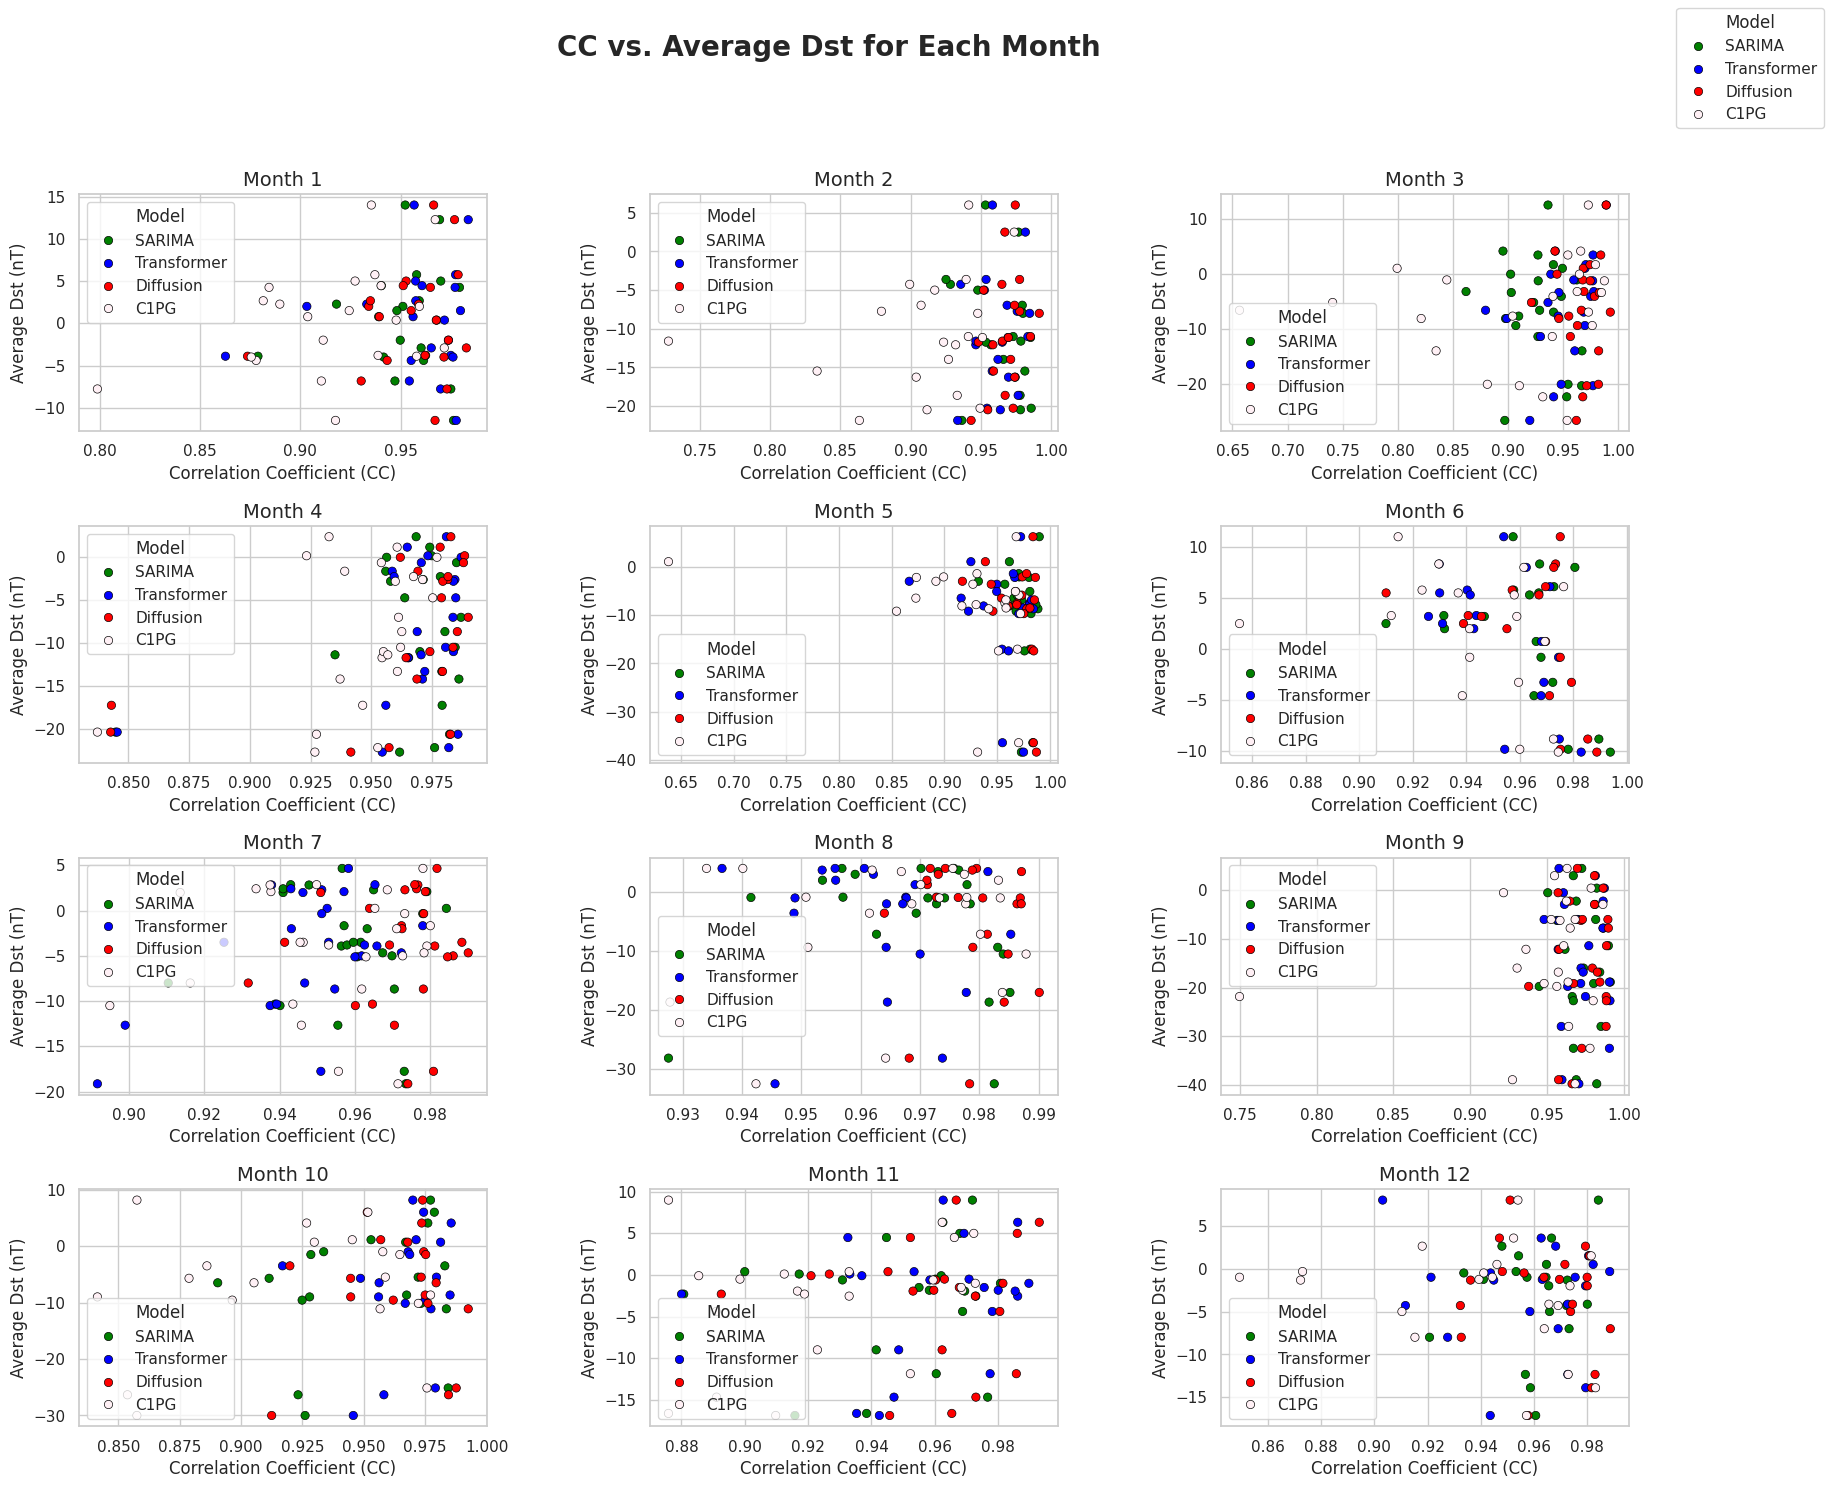

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

arima_results['Model'] = 'SARIMA'
tran_results['Model'] = 'Transformer'
diffusion_results['Model'] = 'Diffusion'
code_results['Model'] = 'C1PG'
# 合并三个DataFrame
cc_results = pd.concat([arima_results, tran_results, diffusion_results, code_results], ignore_index=True)

# 计算平均Dst值的函数
def calculate_avg_dst(row, df):
    start_date = row['Start Date']
    end_date = row['End Date']
    dst_window = df.loc[start_date:end_date]
    return dst_window['Dst'].mean()

# 对cc_results中每一行应用此函数
cc_results['AvgDst'] = cc_results.apply(calculate_avg_dst, df=selected_data, axis=1)
cc_results['Start Date'] = pd.to_datetime(cc_results['Start Date'])
cc_results['Month'] = cc_results['Start Date'].dt.month

# 设置Seaborn风格
sns.set(style="whitegrid", font_scale=1)

# 创建一个4x3的图表网格
fig, axs = plt.subplots(4, 3, figsize=(20, 16))
fig.suptitle('CC vs. Average Dst for Each Month', fontsize=20, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# 遍历每个月
for month, ax in zip(range(1, 13), axs.flatten()):
    monthly_data = cc_results[cc_results['Month'] == month]
    
    if not monthly_data.empty:
        # 使用hue参数区分数据来源
        sns.scatterplot(data=monthly_data, x='CC', y='AvgDst', hue='Model', ax=ax, palette=['green', 'blue', 'red', "LavenderBlush"], edgecolor='black', legend=True)
        
        ax.set_title(f'Month {month}', fontsize=14)
        ax.set_xlabel('Correlation Coefficient (CC)', fontsize=12)
        ax.set_ylabel('Average Dst (nT)', fontsize=12)
    else:
        ax.set_visible(False)

# 添加一个图例
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Model')
# plt.savefig('./d3vae/exp/cc_all_2019.pdf', dpi=100)
plt.show()


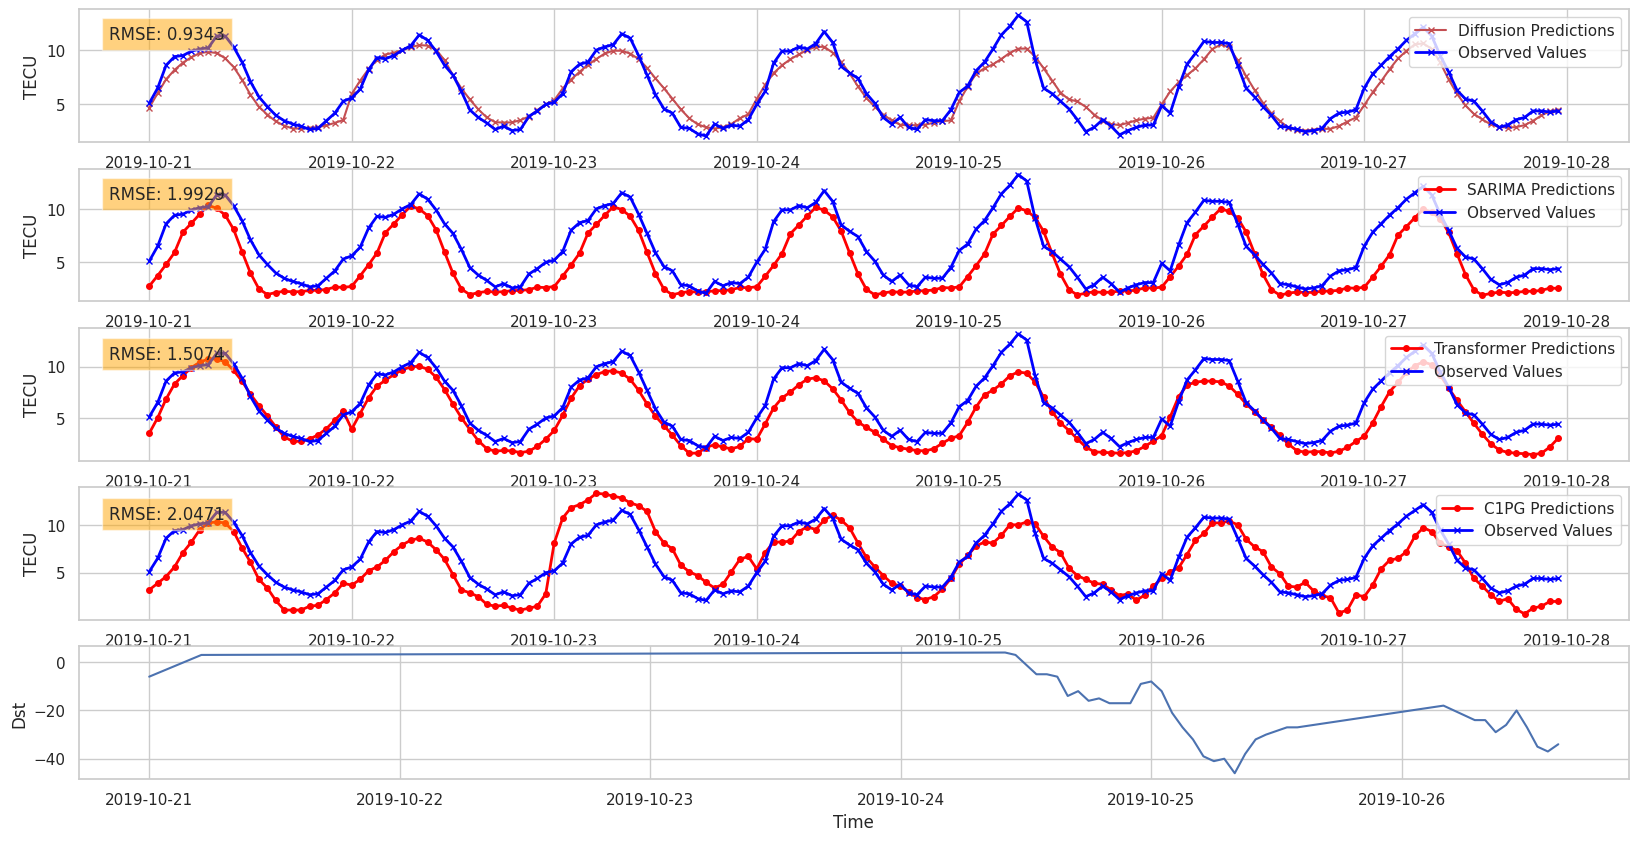

In [79]:
input_data = real['2019-10-21':'2019-10-27']
arima_pred_data = arima_data['2019-10-21':'2019-10-27']
diffusion_pred_data = pred['2019-10-21':'2019-10-27']
tran_pred_data = pre_tran['2019-10-21':'2019-10-27']
dst_data = selected_data['2019-10-21':'2019-10-27']
c1pg=code['2019-10-21':'2019-10-27']
fig, axs = plt.subplots(5, 1, figsize=(20, 10))  # 创建两个垂直子图

dw = dfraw['2019-10-21':'2019-10-27']

axs[0].plot(diffusion_pred_data, color="r", label="Diffusion Predictions", marker='x', linestyle='-', markersize=4)
axs[0].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse1 = RMSE(dw, diffusion_pred_data)
axs[0].legend(loc='upper right')
axs[0].set_ylabel('TECU')
plt.figtext(0.14, 0.85, f'RMSE: {rmse1:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


axs[1].plot(arima_pred_data, color='red', label='SARIMA Predictions', marker='o',linewidth=2, markersize=4)
axs[1].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse = RMSE(arima_pred_data, dw)
axs[1].legend(loc='upper right')
axs[1].set_ylabel('TECU')
plt.figtext(0.14, 0.69, f'RMSE: {rmse:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

axs[2].plot(tran_pred_data, color='red', label='Transformer Predictions', marker='o',linewidth=2, markersize=4)
axs[2].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse2 = RMSE(tran_pred_data, dw)
axs[2].legend(loc='upper right')
axs[2].set_ylabel('TECU')
plt.figtext(0.14, 0.53, f'RMSE: {rmse2:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


axs[3].plot(c1pg, color='red', label='C1PG Predictions', marker='o',linewidth=2, markersize=4)
axs[3].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse2 = RMSE(c1pg, dw)
axs[3].legend(loc='upper right')
axs[3].set_ylabel('TECU')
plt.figtext(0.14, 0.37, f'RMSE: {rmse2:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})



axs[4].plot(selected_data['2019-10-21':'2019-10-27']['Dst'], linestyle='-', color='b')
axs[4].set_ylabel('Dst')
axs[4].set_xlabel('Time')
# plt.savefig('/home/yyh/d3vae/exp/20192.pdf', dpi=300)
plt.show()


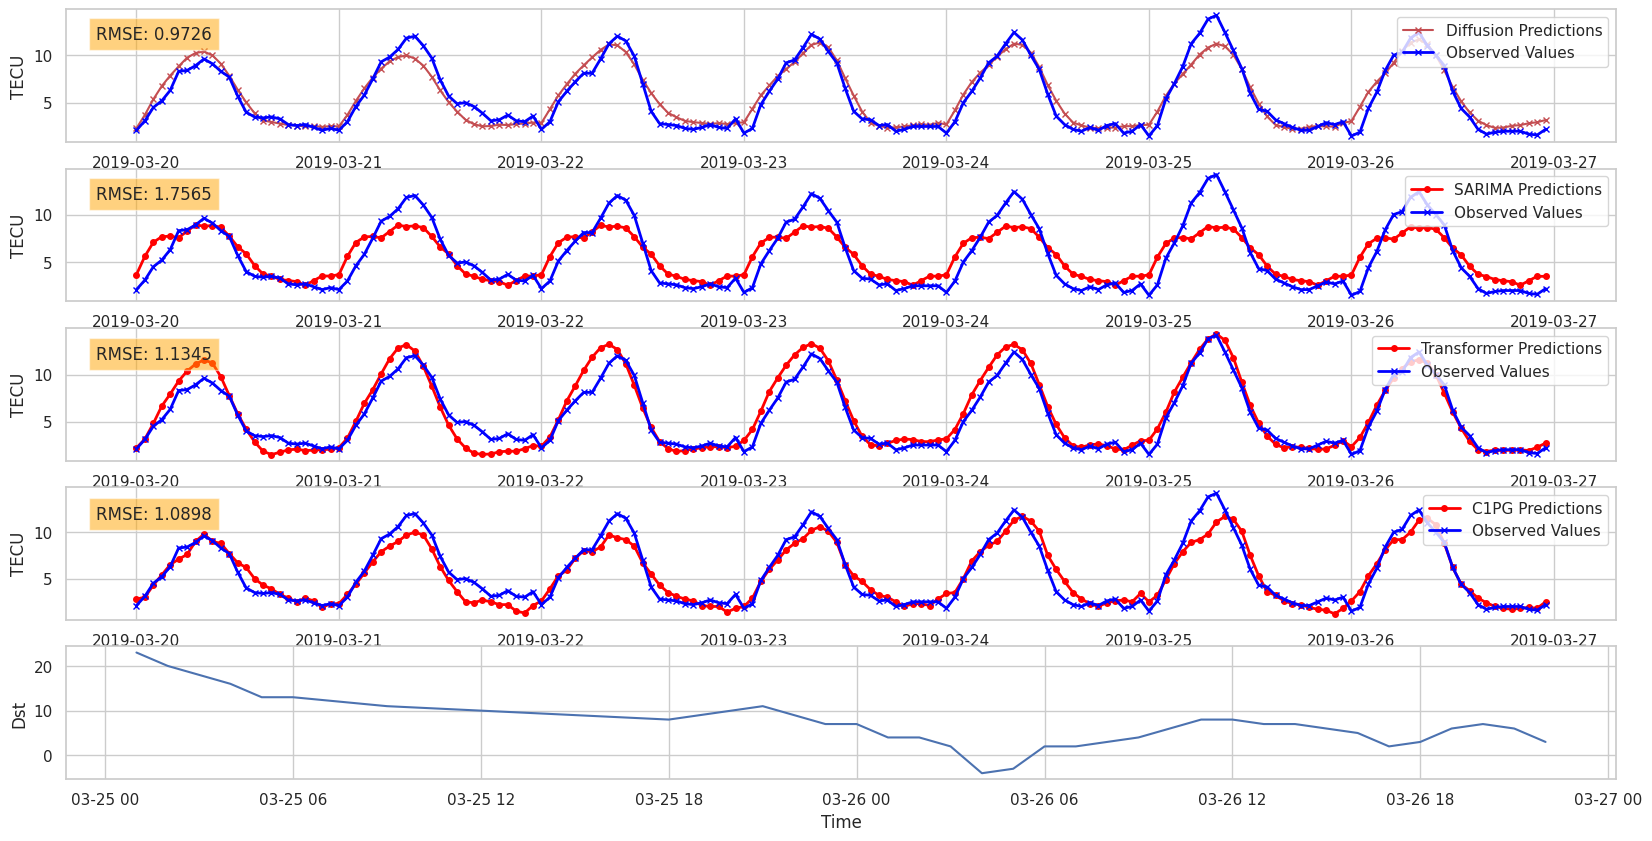

In [80]:
input_data = real['2019-03-20':'2019-03-26']
arima_pred_data = arima_data['2019-03-20':'2019-03-26']
diffusion_pred_data = pred['2019-03-20':'2019-03-26']
tran_pred_data = pre_tran['2019-03-20':'2019-03-26']
dst_data = selected_data['2019-03-20':'2019-03-26']
c1pg=code['2019-03-20':'2019-03-26']

fig, axs = plt.subplots(5, 1, figsize=(20, 10))  # 创建两个垂直子图

dw = dfraw['2019-03-20':'2019-03-26']

axs[0].plot(diffusion_pred_data, color="r", label="Diffusion Predictions", marker='x', linestyle='-', markersize=4)
axs[0].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse1 = RMSE(dw, diffusion_pred_data)
axs[0].legend(loc='upper right')
axs[0].set_ylabel('TECU')
plt.figtext(0.14, 0.85, f'RMSE: {rmse1:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


axs[1].plot(arima_pred_data, color='red', label='SARIMA Predictions', marker='o',linewidth=2, markersize=4)
axs[1].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse = RMSE(arima_pred_data, dw)
axs[1].legend(loc='upper right')
axs[1].set_ylabel('TECU')
plt.figtext(0.14, 0.69, f'RMSE: {rmse:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

axs[2].plot(tran_pred_data, color='red', label='Transformer Predictions', marker='o',linewidth=2, markersize=4)
axs[2].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse2 = RMSE(tran_pred_data, dw)
axs[2].legend(loc='upper right')
axs[2].set_ylabel('TECU')
plt.figtext(0.14, 0.53, f'RMSE: {rmse2:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


axs[3].plot(c1pg, color='red', label='C1PG Predictions', marker='o',linewidth=2, markersize=4)
axs[3].plot(dw, color='blue', label='Observed Values', marker='x',linewidth=2, markersize=4)
rmse2 = RMSE(c1pg, dw)
axs[3].legend(loc='upper right')
axs[3].set_ylabel('TECU')
plt.figtext(0.14, 0.37, f'RMSE: {rmse2:.4f}', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})



axs[4].plot(selected_data['2019-03-21':'2019-03-26']['Dst'], linestyle='-', color='b')
axs[4].set_ylabel('Dst')
axs[4].set_xlabel('Time')
# plt.savefig('/home/yyh/d3vae/exp/20192.pdf', dpi=300)
plt.show()
